<a href="https://colab.research.google.com/github/rorgt/2024-term-project/blob/main/CoLab_TermProj_GO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GO term enrichment analysis for CLIP and ribosome profiling (Fig 5A)



## Transcript count table 준비


* TermProj_2024_1과 동일한 환경 설정, 시퀀싱 데이터 다운로드 과정임.
* 런타임 연결마다 모두 실행하면 됨.


In [1]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 실습용 biconda 환경
!git clone https://github.com/hyeshik/colab-biolab.git
!cd colab-biolab && bash tools/setup.sh
exec(open('colab-biolab/tools/activate_conda.py').read())

Cloning into 'colab-biolab'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 76 (delta 26), reused 59 (delta 15), pack-reused 0
Receiving objects: 100% (76/76), 318.16 KiB | 1.28 MiB/s, done.
Resolving deltas: 100% (26/26), done.
./
./root/
./root/.profile
./root/.tmux.conf
./root/.bin.priority/
./root/.bin.priority/pip2
./root/.bin.priority/pip3
./root/.bin.priority/pip
./root/.vimrc
./root/.bashrc.biolab
./root/.condarc
--2024-06-09 12:28:05--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:20f1, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143808873 (137M) [application/octet-stream]
Saving to: ‘miniconda3.sh’

miniconda3.sh       100%[===================>] 137.15M   

In [3]:
# 시퀀싱 데이터 다운로드 (이미 진행하여 생략, 체크섬 생략)
# !ls -al /content/drive/MyDrive/binfo1-datapack1/

In [4]:
# 프로그램 추가 설치 (이미 featurecount 진행하여 생략)
# !conda install -y subread

In [5]:
# 작업 디렉토리 만들고 복사하기 (이미 진행하여 생략)
# !mkdir /content/drive/MyDrive/binfo1-work
# !chmod +777 /content/drive/MyDrive/binfo1-work
# !cp -f /content/drive/MyDrive/binfo1-datapack1/*.* /content/drive/MyDrive/binfo1-work/

In [6]:
%cd /content/drive/MyDrive/binfo1-work

/content/drive/MyDrive/binfo1-work


In [7]:
# bam (aligned reads), gtf (annotation) -> gene 별 read count (이미 진행하여 생략)
# !featureCounts -a gencode.gtf -o read-counts.txt *.bam

## Gene ID별 좌표, GO df 준비

* transcript count table 중 발현이 낮은 값 제거한 뒤 좌표(clip, rden) 값을 계산함.
* GO는 Biomart에서 .tsv로 받았음. (6/6/24 기준 빌드 버전 GRCm39)
* 버전 제거 Gene ID를 기준으로 좌표와 GO를 합친 merged df을 생성함.

In [8]:
import pandas as pd
import numpy as np

In [9]:
cnts = pd.read_csv('read-counts.txt', sep='\t', comment='#', index_col=0)

print(cnts.shape)
cnts.head()

(55359, 13)


,Chr,Start,End,Strand,Length,CLIP-35L33G.bam,CLIP-let7g.bam,filtered-RPF-siLuc.bam,RNA-control.bam,RNA-siLin28a.bam,RNA-siLuc.bam,RPF-siLin28a.bam,RPF-siLuc.bam
Geneid,,,,,,,,,,,,,
ENSMUSG00000102693.2,chr1,3143476,3144545,+,1070,0,0,0,0,0,0,0,0
ENSMUSG00000064842.3,chr1,3172239,3172348,+,110,0,0,0,0,0,0,0,0
ENSMUSG00000051951.6,chr1;chr1;chr1;chr1;chr1;chr1;chr1,3276124;3276746;3283662;3283832;3284705;349192...,3277540;3277540;3285855;3286567;3287191;349212...,-;-;-;-;-;-;-,6094,4,0,0,1,1,1,0,0
ENSMUSG00000102851.2,chr1,3322980,3323459,+,480,3,0,0,0,0,0,0,0
ENSMUSG00000103377.2,chr1,3435954,3438772,-,2819,0,0,0,0,0,0,0,0


In [10]:
# count가 낮은 gene 정리
fcnts = cnts[(cnts['CLIP-35L33G.bam'] > 0) &
  (cnts['RNA-control.bam'] > 30) &
  (cnts['RPF-siLin28a.bam'] > 0) &
  (cnts['RNA-siLin28a.bam'] > 0) &
  (cnts['RPF-siLuc.bam'] > 0) &
  (cnts['RNA-siLuc.bam'] > 80)
  ]

# 필요한 column만 남김
fcnts = fcnts[
    ['CLIP-35L33G.bam', 'RNA-control.bam', 'RPF-siLin28a.bam', 'RNA-siLin28a.bam', 'RPF-siLuc.bam', 'RNA-siLuc.bam']
    ]

print(fcnts.shape)
fcnts.head()

(9519, 6)


,CLIP-35L33G.bam,RNA-control.bam,RPF-siLin28a.bam,RNA-siLin28a.bam,RPF-siLuc.bam,RNA-siLuc.bam
Geneid,,,,,,
ENSMUSG00000102343.2,67,31,1,207,2,157
ENSMUSG00000103922.2,183,95,42,93,75,100
ENSMUSG00000033845.14,4014,1355,1859,3022,3191,2563
ENSMUSG00000025903.15,2045,574,33,1219,44,1236
ENSMUSG00000033813.16,1658,762,328,2130,609,2225


In [11]:
# scatter의 좌표가 될 column 추가 (TermProj_2024_1)
fcnts['clip_enrichment'] = np.log2(fcnts['CLIP-35L33G.bam'] / fcnts['RNA-control.bam'])
fcnts['rden_change'] = np.log2((fcnts['RPF-siLin28a.bam'] / fcnts['RNA-siLin28a.bam']) / (fcnts['RPF-siLuc.bam'] / fcnts['RNA-siLuc.bam']))

# index를 해제한 후 버전 제거한 gene ID column 추가
fcnts.reset_index(inplace=True)
fcnts['Gene stable ID'] = fcnts['Geneid'].str.split('.').str.get(0)

# 새로운 좌표 데이터프레임 생성
columns_to_keep_2 = ['Gene stable ID', 'clip_enrichment', 'rden_change']
gene_change = fcnts[columns_to_keep_2]

print(gene_change.shape)
print(gene_change.drop_duplicates().shape)
gene_change.head()

(9519, 3)
(9519, 3)


,Gene stable ID,clip_enrichment,rden_change
0,ENSMUSG00000102343,1.111893,-1.398866
1,ENSMUSG00000103922,0.945844,-0.731804
2,ENSMUSG00000033845,1.566748,-1.017152
3,ENSMUSG00000025903,1.832978,-0.395057
4,ENSMUSG00000033813,1.121581,-0.829795


In [12]:
# GO from Ensembl Biomart
gene_go = pd.read_csv('GO_mart_GRCm39.tsv', sep='\t').dropna()

print(gene_go.shape)
gene_go.head()

(373180, 4)


,Gene stable ID,GO term name,GO term accession,GO domain
0,ENSMUSG00000064336,translational elongation,GO:0006414,biological_process
1,ENSMUSG00000064336,triplet codon-amino acid adaptor activity,GO:0030533,molecular_function
2,ENSMUSG00000064336,mitochondrion,GO:0005739,cellular_component
3,ENSMUSG00000064337,ribosomal small subunit assembly,GO:0000028,biological_process
4,ENSMUSG00000064337,translation,GO:0006412,biological_process


In [13]:
# Gene ID를 기준으로 GO와 좌표를 inner join
gene_go_change = gene_go.merge(gene_change, on='Gene stable ID', how='inner')

print(gene_go_change.shape)
gene_go_change.head()

(179905, 6)


,Gene stable ID,GO term name,GO term accession,GO domain,clip_enrichment,rden_change
0,ENSMUSG00000064337,ribosomal small subunit assembly,GO:0000028,biological_process,1.824380,0.414376
1,ENSMUSG00000064337,translation,GO:0006412,biological_process,1.824380,0.414376
2,ENSMUSG00000064337,structural constituent of ribosome,GO:0003735,molecular_function,1.824380,0.414376
3,ENSMUSG00000064337,mitochondrial small ribosomal subunit,GO:0005763,cellular_component,1.824380,0.414376
4,ENSMUSG00000064339,translation,GO:0006412,biological_process,2.607129,0.690727


## GO term별 차이를 검정하기
* GO term별 clip과 rden에 대해 각각 Mann-Whitney U test를 수행함. (8분 소요)
* GO term과 Gene ID가 다대다 대응임에 주의!! Merged df을 바로 쓸 수 없음.
* Multiple testing correction을 위해 FDR Benjamini-Hochberg method를 적용함.

In [14]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [15]:
# Group by 'GO term name'
go = gene_go_change.groupby('GO term name').agg(
    num_genes=('Gene stable ID', 'nunique'),
    clip_avg=('clip_enrichment', 'mean'),
    rden_avg=('rden_change', 'mean')
).reset_index()

print(go.shape)
go.head()

(14998, 4)


,GO term name,num_genes,clip_avg,rden_avg
0,'de novo' AMP biosynthetic process,7,0.472912,-1.640283
1,'de novo' CTP biosynthetic process,2,0.707900,-1.629000
2,'de novo' GDP-L-fucose biosynthetic process,1,-0.845490,-1.179755
3,'de novo' IMP biosynthetic process,6,0.272234,-1.702581
4,'de novo' NAD biosynthetic process,1,-0.174029,-0.885488


In [16]:
# Precompute unique genes for each GO term
go_term_genes = gene_go.groupby('GO term name')['Gene stable ID'].apply(set).to_dict()

# Precompute change values for each gene for faster lookup
gene_clip = gene_change.set_index('Gene stable ID')['clip_enrichment'].to_dict()
gene_rden = gene_change.set_index('Gene stable ID')['rden_change'].to_dict()

# Precompute yes and no changes for all GO terms
clip_yes_no_changes = {}
rden_yes_no_changes = {}

all_genes = set(gene_change['Gene stable ID'])

for go_term, genes in go_term_genes.items():
    yes_genes = genes
    no_genes = all_genes - yes_genes

    clip_yes_no_changes[go_term] = ([gene_clip[gene] for gene in yes_genes if gene in gene_clip],
                                    [gene_clip[gene] for gene in no_genes if gene in gene_clip])

    rden_yes_no_changes[go_term] = ([gene_rden[gene] for gene in yes_genes if gene in gene_rden],
                                    [gene_rden[gene] for gene in no_genes if gene in gene_rden])

# Mann-Whitney U test
def mann_whitney_enrichment_test(yes_changes, no_changes):
    if len(yes_changes) > 1 and len(no_changes) > 1:
        _, p_value = mannwhitneyu(yes_changes, no_changes, alternative='two-sided')
    else:
        p_value = np.nan
    return p_value

# Apply the test for each GO term
clip_p_vals = []
rden_p_vals = []

for go_term in go['GO term name']:
    clip_p_vals.append(mann_whitney_enrichment_test(*clip_yes_no_changes[go_term]))
    rden_p_vals.append(mann_whitney_enrichment_test(*rden_yes_no_changes[go_term]))

# Add p-values to the DataFrame
go['clip_p_val'] = clip_p_vals
go['rden_p_val'] = rden_p_vals

In [17]:
# Drop rows with NaN p-values
go_fdr = go.dropna(subset=['clip_p_val', 'rden_p_val']).copy()

# FDR correction
clip_p_values = go_fdr['clip_p_val']
rden_p_values = go_fdr['rden_p_val']

go_fdr['clip_fdr'] = multipletests(clip_p_values, method='fdr_bh')[1]
go_fdr['rden_fdr'] = multipletests(rden_p_values, method='fdr_bh')[1]

# Filter for FDR < 0.05 for easier visualization
go_fdr = go_fdr[(go_fdr['clip_fdr'] < 0.05) & (go_fdr['rden_fdr'] < 0.05)]

# Sort and set index for easier visualization
go_fdr = go_fdr.sort_values(by='num_genes', ascending=False)
go_fdr.set_index('GO term name', drop=True, inplace=True)

print(go_fdr.shape)
go_fdr.head(20)

(119, 7)


,num_genes,clip_avg,rden_avg,clip_p_val,rden_p_val,clip_fdr,rden_fdr
GO term name,,,,,,,
cytoplasm,4254,0.625985,-1.008226,1.753805e-28,5.516549e-117,4.410819e-25,1.849883e-113
nucleus,4027,0.694918,-1.023576,2.461226e-07,3.530167e-125,9.903974e-05,1.775674e-121
membrane,3115,1.118767,-0.585535,4.307607e-72,9.518890e-202,4.333452e-68,9.576003e-198
cytosol,2707,0.606779,-1.032322,1.967366e-17,1.714476e-75,2.199077e-14,2.463947e-72
nucleoplasm,2409,0.660945,-1.050639,1.251539e-07,1.792230e-80,5.246034e-05,3.004972e-77
plasma membrane,1686,1.028490,-0.708675,2.057033e-19,6.580072e-26,2.956250e-16,3.008887e-23
mitochondrion,1286,0.631176,-0.805575,4.482671e-07,1.385407e-04,1.610559e-04,4.805928e-03
DNA binding,981,0.645594,-1.081091,4.388535e-04,1.622381e-36,3.773390e-02,1.165797e-33
endoplasmic reticulum,946,1.427805,-0.433166,8.144135e-61,3.984846e-113,4.096500e-57,1.002189e-109


## Visualization
* 내가 반영한 부분:
  * GO term별로 평균 CLIP, rden (log2 scale이었음) 을 좌표로 하는 산점도를 그렸음.
  * colormap은 FDR로 나타내되, clip에 대한 FDR만 반영하였음.
  * annotation에 GO term 이름과 괄호 안에 number of genes, C와 R 옆에 clip과 rden에 대한 FDR을 기입하였음. (원본은 p-value?)
  * dpi 3000부터는 RAM 한도에 도달하여 런타임 끊기므로 시도하지 말 것.
* 원본 설명:
  * Each circle represents a **GO term**.
  * The **color intensity** indicates statistical significance of enrichment or depletion determined by **Mann-Whitney U test**.
  * The **size of the circle** corresponds to **the number of genes**.
  * The **coordinates** indicate average CLIP tag enrichment (x axis) and ribosome density change (y axis).
  * Balloons contain the **number of genes** (written in parentheses) and p values for CLIPseq (C) and ribosome footprinting (R).
  * Note that nucleosome-related terms are overestimated artificially in CLIP because of a normalization problem due to the lack of polyA tail in histone mRNAs.

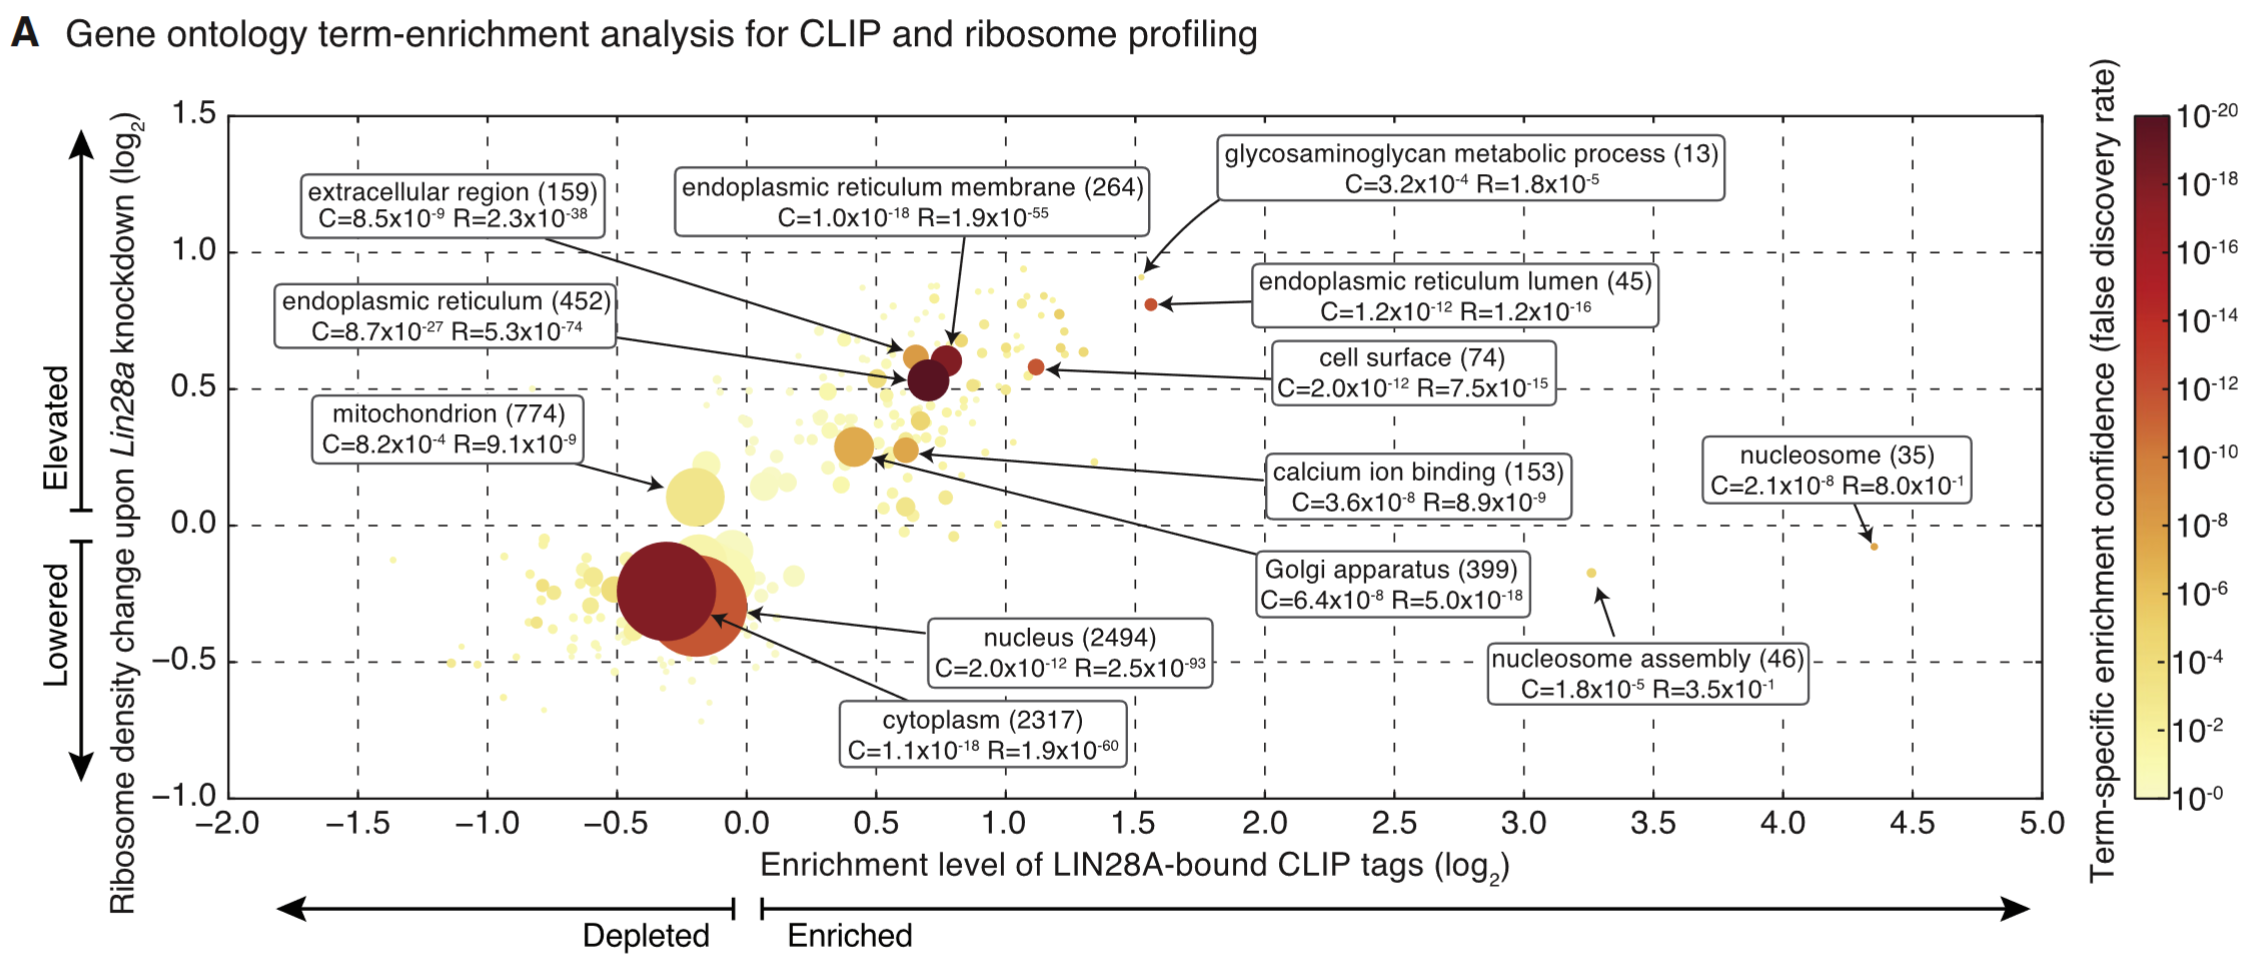

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

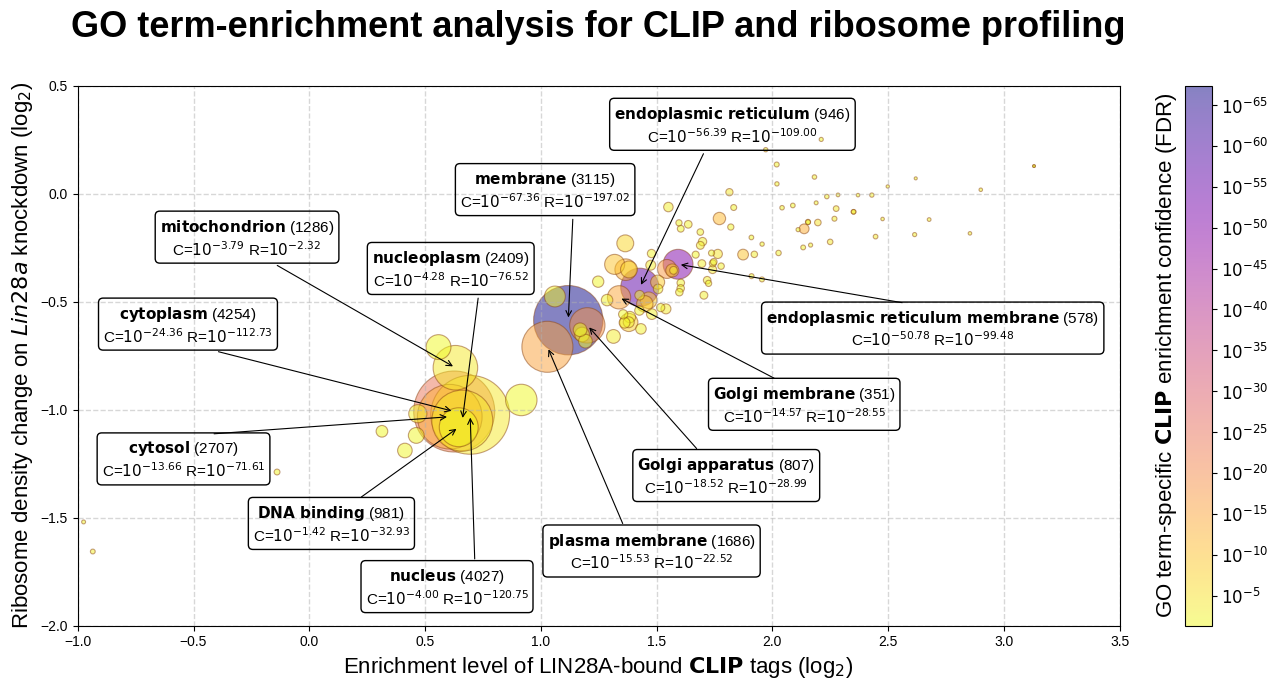

In [19]:
# Visualization
plt.rcParams['font.family'] = 'Liberation Sans'
plt.figure(figsize=(14, 7))

# Scatter plot
sc = plt.scatter(
    go_fdr['clip_avg'],
    go_fdr['rden_avg'],
    s=go_fdr['num_genes']*0.8,  # size
    c=np.log10(go_fdr['clip_fdr']),  # color intensity
    #c=go_fdr[['clip_fdr', 'rden_fdr']].apply(lambda x: min(np.log10(x[0]), np.log10(x[1])), axis=1),
    cmap='plasma',  # Pastel1 cubehelix bone copper
    alpha=0.5,
    edgecolors='saddlebrown',
    linewidth=0.8
)

# Add a color bar
cbar = plt.colorbar(sc)
cbar.set_label('GO term-specific $\\bf{{CLIP}}$ enrichment confidence (FDR)', fontsize=16)
cbar.ax.tick_params(labelsize=12)
cbar.ax.yaxis.set_label_position('left')
cbar.ax.invert_yaxis()

# Customize the color bar ticks
#log_min = np.floor(np.log10(go_fdr[['clip_fdr', 'rden_fdr']].min().min()))
#log_max = np.ceil(np.log10(go_fdr[['clip_fdr', 'rden_fdr']].max().max()))
cbar.set_ticks(np.arange(-65, 0, 5))
cbar.set_ticklabels([f'$10^{{{int(tick)}}}$' for tick in np.arange(-65, 0, 5)])

# Set x and y axis
plt.xlim([-0.5, 2.0])
plt.ylim([-2, 0])
plt.xticks(np.arange(-1, 4, 0.5))
plt.yticks(np.arange(-2, 1, 0.5))
plt.xlabel('Enrichment level of LIN28A-bound $\\bf{{CLIP}}$ tags (log$_{2}$)', fontsize=16)
plt.ylabel('Ribosome density change on $\it{Lin28a}$ knockdown (log$_{2}$)', fontsize=16)
plt.title('GO term-enrichment analysis for CLIP and ribosome profiling\n', fontsize=26, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=1, alpha=0.5)

# Define function to add annotation with arrow
def add_annotation(row, text_offset=(0.2, 0.2), arrow_offset=None):
    spacing = 0.12
    go_term_bold = row.name.replace(' ', '\ ')
    arrow_offset = (text_offset[0] - spacing if text_offset[0] > 0 else text_offset[0] + spacing,
                    text_offset[1] - spacing if text_offset[1] > 0 else text_offset[1] + spacing) if arrow_offset is None else arrow_offset
    plt.text(row['clip_avg'] + text_offset[0], row['rden_avg'] + text_offset[1],
             f"$\\bf{{{go_term_bold}}}$ ({row['num_genes']:.0f})\nC=$10^{{{np.log10(row['clip_fdr']):.2f}}}$ R=$10^{{{np.log10(row['rden_fdr']):.2f}}}$",
             fontsize=11, ha='center', va='center',
             bbox=dict(facecolor='none', alpha=1, edgecolor='black', boxstyle='round,pad=0.3'))
    plt.annotate("", xy=(row['clip_avg'], row['rden_avg']), xytext=(row['clip_avg'] + arrow_offset[0], row['rden_avg'] + arrow_offset[1]),
                 arrowprops=dict(arrowstyle="->", linewidth=0.8, color='black', alpha=1))

# Dictionary to specify text offsets for each GO term
annotation_offsets = {
    'nucleus': (-0.1, -0.8),
    'nucleoplasm': (-0.05, 0.7),
    'cytosol': (-1.15, -0.2),
    'cytoplasm': (-1.15, 0.4),
    'mitochondrion': (-0.9, 0.6),
    'plasma membrane': (0.45, -0.95),
    'membrane': (-0.1, 0.6),
    'endoplasmic reticulum': (0.4, 0.75),
    'endoplasmic reticulum membrane': (1.1, -0.3),
    # 'endoplasmic reticulum lumen': (1.1, -0.3),
    'Golgi apparatus': (0.6, -0.7),
    'Golgi membrane': (0.8, -0.5),
    'DNA binding': (-0.55, -0.45),
}

# Add text annotations for each specified GO term with its offsets
for go_term, text_offset in annotation_offsets.items():
    row = go_fdr.loc[go_term]
    add_annotation(row, text_offset=text_offset)

plt.tight_layout()
#plt.savefig("Figure 5A", format="png", dpi=2000)
plt.show()